<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 11: Vector de corrección de errores (VEC)</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Valores críticos de MacKinnon para test de cointegración</div> 
</center>
<i>Creado:     2017-May-16 
    <br>
    Actualizado: 2020-Oct-25</i>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('precision',5)
%matplotlib inline

Las tablas de MacKinnon están almacenadas en un archivo de Excel, el cual importamos con Pandas cuando creamos la clase MacKinnon.  Guardar estas tablas en una clase tiene la ventaja de que así no será necesario leer el archivo de Excel cada vez que se quiera obtener nuevos valores críticos.

In [2]:
source_file = r"MacKinnon 2010 Critical values for cointegration tests.xlsx"

# Una clase para el test de MacKinnon

In [3]:
class MacKinnon:
    variants = {'nc': 'No constant term',
                'c': 'Constant term',
                'ct': 'Constant and linear trend',
                'ctt': 'Constant, linear trend and quadratic trend'}

    tables = {tt: pd.read_excel(source_file, tt)
              for tt in variants.keys()}

    def get_matrix(self, variant, N, level=None):
        '''
        get_matrix(self, variant, N, level=None)
        
        Retorna la parte relevante de la tabla de MacKinnon para una prueba
        de cointegración de N series, con la variante especificada ('nc', 'c', 
        'ct', o 'ctt'). 
        
        Opcionalmente, si además se especifica el nivel de la prueba ('1%', '5%' 
        o '10%'), se retorna un vector con los betas requeridos.
        
        En ambos casos, los betas están ordenados de mayor orden a menor; esto 
        facilita la evaluación posterior del polinomio usando np.polyval
        '''
        
        dd = self.tables[variant]
        temp = dd[dd.N == N][['Level', 'beta3', 'beta2', 'beta1', 'beta_inf']]
        temp.set_index('Level', drop=True, inplace=True)
        
        return temp.loc[level] if level else temp

    def __call__(self, variant, N, T, level=None):
        '''
        Retorna los valores críticos de MacKinnon para una prueba de cointegración
        de N series, con la variante especificada ('nc', 'c', 'ct', o 'ctt'). 
        
        Opcionalmente, si además se especifica el nivel de la prueba ('1%', '5%' 
        o '10%'), se retorna unícamente el escalar requerido.
        '''
        beta = self.get_matrix(variant, N, level)
        if level:
            return np.polyval(beta, 1/T)
        else:
            values = [np.polyval(k, 1/T) for k in beta.values]
            return pd.Series(values, index=beta.index)

In [4]:
mk = MacKinnon()

El valor crítico al 5% para determinar si 5 series están cointegradas, basados en 100 observaciones, incluyendo intercepto y tendencia lineal

In [5]:
mk('ct', N=5, T=100, level='5%')

-4.8911136410000005

Si no especificamos el nivel de significancia, la función muestra los valores usuales de 1%, 5% y 10%

In [6]:
mk('ct', N=5, T=100)

Level
1%    -5.52086
5%    -4.89111
10%   -4.57125
dtype: float64

Para obtener los coeficientes del polinomio de approximación, usamos **get_matrix**

In [7]:
mk.get_matrix('ct', N=5)

,beta3,beta2,beta1,beta_inf
Level,,,,
1%,50.646,-59.631,-26.2183,-5.25276
5%,91.359,-22.660,-17.3569,-4.71537
10%,76.781,-10.238,-13.6078,-4.43422


In [8]:
mk.get_matrix('ct', N=5, level='5%')

beta3       91.35900
beta2      -22.66000
beta1      -17.35690
beta_inf    -4.71537
Name: 5%, dtype: float64

Evaluamos otra vez el valor crítico al 5% para determinar si 5 series están cointegradas, basados en 100 observaciones, incluyendo intercepto y tendencia lineal, esta vez evaluando el polinomio a partir de los coeficientes

In [9]:
b3,b2,b1,b0 = mk.get_matrix('ct', N=5, level='5%')
T = 100
b0 + b1 / T + b2 / T**2 + b3 / T**3

-4.891113641

Igual que en el caso anterior, pero usando la función **polyval** de numpy para evaluar el polinomio

In [10]:
tb = mk.get_matrix('ct', N=5, level='5%')
np.polyval(tb, 1/T)

-4.8911136410000005

## Valores críticos versus tamaño de muestra
Para muestras pequeñas, los valores críticos son mayores (en valor absoluto)

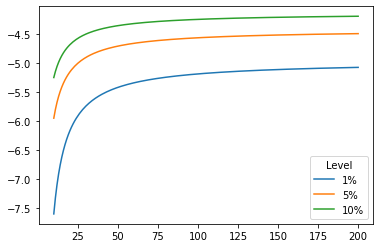

In [11]:
sample_sizes = np.arange(10, 201)
vT = pd.DataFrame([MacKinnon()('c',5,T) for T in sample_sizes], 
                 index=sample_sizes)
vT.plot()


## Valores críticos versus número de series
Entre más series hayan en el vector de cointegración, los valores críticos son mayores (en valor absoluto)

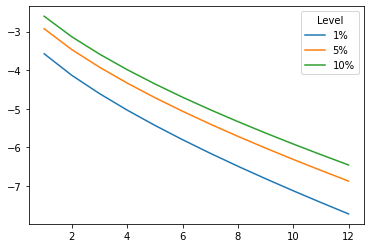

In [12]:
number_of_series = np.arange(1, 13)
vN = pd.DataFrame([MacKinnon()('c',N,48) for N in number_of_series], 
                 index=number_of_series)
vN.plot()

## Valores críticos versus tendencias determinísticas
Entre más elementos haya en la tendencia determinística, mayores serán los valores críticos (en valor absoluto)

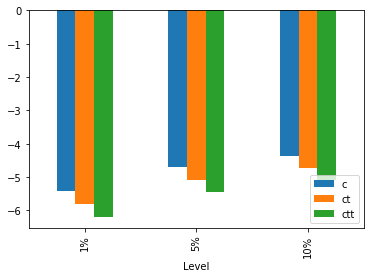

In [13]:
variants = ['c','ct', 'ctt']
vV = pd.DataFrame([MacKinnon()(v,5,48) for v in variants], 
                 index=variants)
vV.T.plot(kind='bar')